## 2. Masking AKA Clipping with Rasterio

Okay--I admit this is slightly complicated, but doing GIS in the wild can be that way sometimes!  

There's a bunch of ways you may want to clip something, so consider this a primer on what it really takes to clip a raster.  
Essentially, you need:
1. An input image
2. Something you want to clip it with, in this case, we'll use the extent of a shapefile
3. You need the raw geometry of your clipping object, and rasterio wants it formatted in a Python dictionary GeoJSON style... 
4. And of course you need all of the critical descriptive information to go along with these such as the CRS, the transformation, the width, the height, the color profile...  

Let's do it!

In [1]:
import rasterio as rio
from rasterio.plot import show
from rasterio.mask import mask #this is the masking aka clip module
import matplotlib.pyplot as plt
import geopandas as gpd #to read the input shapefile
import shapely #to transform extent into coordinate geometries
import json
import os

Important: only run this once or you'll wind up in the wrong directory.
```python
os.chdir('../')
os.getcwd()
```

In [ ]:
os.chdir('../')
os.getcwd()

First, let's read in the image:
```python
src = rio.open('workshopdata/NAIP_Boulder.tif')
```

In [2]:
src = rio.open('workshopdata/NAIP_Boulder.tif')

Let's take a peek:
```python
show(src.read(1))
```

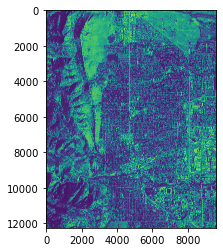

<AxesSubplot:>

In [3]:
show(src.read(1))

Big image! In fact, too big for us to all run stuff on it together... so let's clip so that we're only working with the campus area...  

Read in the campus shapefile:
```python
shape = gpd.read_file('workshopdata/UCB_MainCampus_Boundaries.shp')
```

In [4]:
shape = gpd.read_file('workshopdata/UCB_MainCampus_Boundaries.shp')

Let's take a look:
```python
shape.plot(figsize = (12,12))
```

<AxesSubplot:>

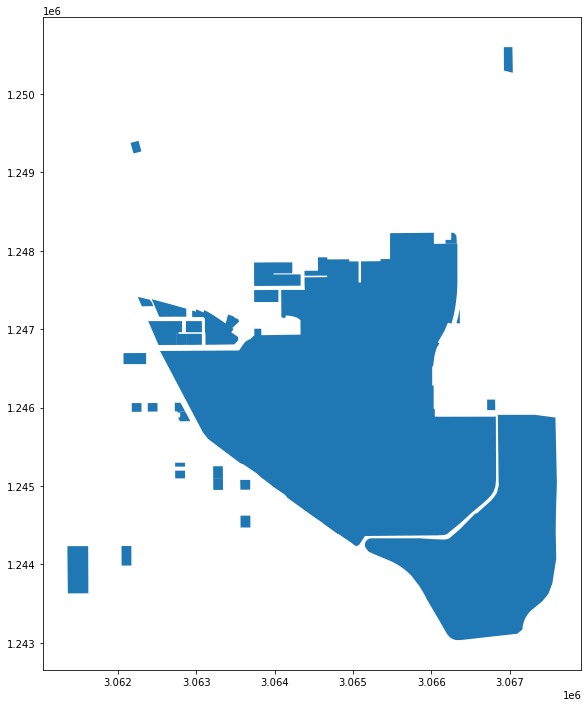

In [5]:
shape.plot(figsize = (12,12))

Okay, but if we're going to clip with this, it needs to be in the same CRS as the image, this is easy to change using geopandas:
```python
src.crs
```

In [6]:
src.crs

CRS.from_epsg(26913)

Change it to EPSG 26913
```python
shape = shape.to_crs(26913)
```

In [7]:
shape = shape.to_crs(26913)

Now let's get the extent of this and use it as our clipping geometry...  



First, we'll use geopandas to get the extent:  
geoseries.total_bounds Returns a tuple containing minx, miny, maxx, maxy values for the bounds of the series as a whole.
```python
shape.total_bounds
```

In [8]:
shape.total_bounds

array([ 476017.15757867, 4427820.35711641,  477921.05398906,
       4430124.12122925])

Does this seem right?
```python
src.bounds
```

In [9]:
src.bounds

BoundingBox(left=473124.0, bottom=4427586.0, right=478878.0, top=4434942.0)

Save it as a variable:
```python
extent = shape.total_bounds
```

In [10]:
extent = shape.total_bounds

But what we have here are really xmin, ymin, xmax, ymax...  

What we need are coordinates of the four corners of this box... 

So we'll use the [Shapely](https://pypi.org/project/shapely/) library to convert these values to a box with actual point coordinates in the corners.  
```python
bbox = shapely.geometry.box(*extent)
```

In [11]:
bbox = shapely.geometry.box(*extent)

Look right? 
```python
print(bbox)
```

In [12]:
print(bbox)

POLYGON ((477921.0539890607 4427820.357116409, 477921.0539890607 4430124.121229252, 476017.1575786665 4430124.121229252, 476017.1575786665 4427820.357116409, 477921.0539890607 4427820.357116409))


Now we have a couple of more steps... although there are probably many ways to do this, I find this reasonably easy.

First bring it into a geopandas dataframe:
```python
geom = gpd.GeoDataFrame({'geometry': bbox}, index=[0], crs=26913)
```

In [13]:
geom = gpd.GeoDataFrame({'geometry': bbox}, index=[0], crs=26913)

Now convert that geopandas geodataframe into geojson (which is the same as a Python dictionary.)
```python
geojson = geom.to_json()
```

In [14]:
geojson = geom.to_json()

Take a peek if you're not familiar:
```python
geojson
```

In [15]:
geojson

'{"type": "FeatureCollection", "features": [{"id": "0", "type": "Feature", "properties": {}, "geometry": {"type": "Polygon", "coordinates": [[[477921.0539890607, 4427820.357116409], [477921.0539890607, 4430124.121229252], [476017.1575786665, 4430124.121229252], [476017.1575786665, 4427820.357116409], [477921.0539890607, 4427820.357116409]]]}}]}'

Now, here what we're doing is using the json library to just get the part we need... that is, only the geometry element, not all the other stuff. 

So, here we select what we need (parse) from the json:
```python
bbox_geom = [json.loads(geojson)['features'][0]['geometry']]
```

In [16]:
bbox_geom = [json.loads(geojson)['features'][0]['geometry']]

Okay, so you should now have a list that contains the bounding box coordinate geometry:
```python
print(bbox_geom)
```

In [17]:
print(bbox_geom)

[{'type': 'Polygon', 'coordinates': [[[477921.0539890607, 4427820.357116409], [477921.0539890607, 4430124.121229252], [476017.1575786665, 4430124.121229252], [476017.1575786665, 4427820.357116409], [477921.0539890607, 4427820.357116409]]]}]


Perfect!  

You may be asking: Why does it want it this way???  

Because, even though this time we're only clipping by one geometry, if it's formatted as a dict/geojson you can have multiple geometries aka multiple vector features to clip with... (see below)  

Now finally, we can run the mask function to get the clipped image. mask() will return two things: the image, and it's affine transformation:
```python
out_img, out_transform = mask(src, bbox_geom, crop=True)
```

In [18]:
out_img, out_transform = mask(src, bbox_geom, crop=True)

Let's take a look...
```python
show(out_img)
```

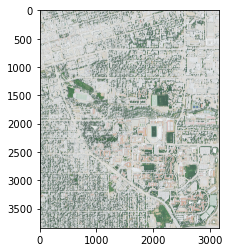

<AxesSubplot:>

In [19]:
show(out_img)

Cool, clip done... if you think the color looks weird, don't worry we'll sort that out when we write the final image...  
   
... now to save it we'll use same approach as before by repurposing the profile:
```python
src.profile
```

In [20]:
src.profile

{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': None, 'width': 9590, 'height': 12260, 'count': 4, 'crs': CRS.from_epsg(26913), 'transform': Affine(0.6, 0.0, 473124.0,
       0.0, -0.6, 4434942.0), 'tiled': False, 'interleave': 'pixel'}

Copy it to a variable:
```python
profile = src.profile.copy()
```
(Note, this is the same as the kwargs variable we used in the last notebook)

In [21]:
profile = src.profile.copy()

Grab the height and the width of the output image:
```python
height = out_img.shape[1]
width = out_img.shape[2]
```

In [22]:
height = out_img.shape[1]
width = out_img.shape[2]

Update the profile. Since we have a new transform, a new width & height, we need to use the `.update` method to take the old profile and update certain elements:
```python
profile.update(transform = out_transform, 
               width = width, 
               height = height, 
               photometric = 'rgb', 
               alpha = 'no')
```
(more on photometric & alpha in the next notebook)

In [23]:
profile.update(transform = out_transform, 
               width = width, 
               height = height, 
               photometric = 'rgb', #<--more on this in the next notebook
               alpha = 'no') #<--more on this in the next notebook

Open a new empty dataset:
```python
new = rio.open('NAIP_Campus_Clip.tif', 'w', **profile)
```

In [24]:
new = rio.open('NAIP_Campus_Clip.tif', 'w', **profile)

Write it to disc:
```python
new.write(out_img)
```

In [25]:
new.write(out_img)

Close it...
```python
new.close()
```

In [26]:
new.close()

#### Done!  


#### Bonus: Multiple geometries...   
Though, I have a hard time coming up with scenarios when you would do it this way, but maybe!  

What will happen here is, everything beyond the extent of the image (aka, bounds) will be gone, but areas within the extent that are outside of the polygons will remain as no data values...  

First, rather than the bounding box, we'll take the original shapefile geodataframe and convert it to geojson:
```python
geojson = shape.to_json()
```

In [27]:
geojson = shape.to_json()

Add the geometries of each polygon feature to a list:
```python
clip_geoms = []
for i in json.loads(geojson)['features']:
    clip_geoms.append(i['geometry'])
```

In [28]:
clip_geoms = []
for i in json.loads(geojson)['features']:
    clip_geoms.append(i['geometry'])

#### Or,
slightly faster list comprehension method:
```python
clip_geoms = [q['geometry'] for q in json.loads(geojson)['features']]
```

In [29]:
clip_geoms = [q['geometry'] for q in json.loads(geojson)['features']]

Then, same process as we used before:

In [30]:
out_img, out_transform = mask(src, clip_geoms, crop=True)

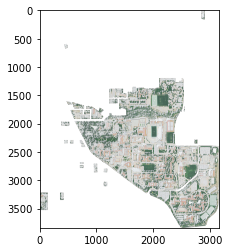

<AxesSubplot:>

In [31]:
show(out_img)

In [32]:
profile = src.profile.copy()
height = out_img.shape[1]
width = out_img.shape[2]

Except this time, we update the `'nodata'` value in the profile to `0`:

In [33]:
profile.update(transform = out_transform, 
               width = width, 
               height = height, 
               nodata = 0,
               photometric = 'rgb', 
               alpha = 'no')

In [34]:
new = rio.open('NAIP_Campus_Clip2.tif', 'w', **profile)
new.write(out_img)
new.close()